# Evaluación de modelos

## Ejecución

En principio solo modificar la variable `model_name` con el nombre del modelo que generó los resultados, y las celdas **Input** de cada problema de clasificación para almacenar los resultados en los correspondientes `y_true`, `y_pred` e `y_proba`.  

Tener en cuenta que para `y_proba` se espera que mediante la expresión
```python
y_proba["y_proba_i"]
```
se pueda acceder a la lista de probabilidades asignadas a la clase $i$ de todas las instancias.

## Notas

Hay métricas de las decisiones (clase predicha), y métricas de los scores (probabilidades asignadas por clase)
 
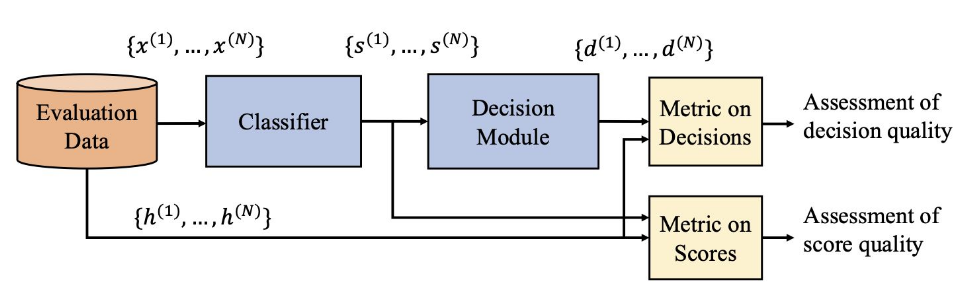

Cálculo de Balanced Accuracy ([fuente](https://arxiv.org/pdf/2008.05756))

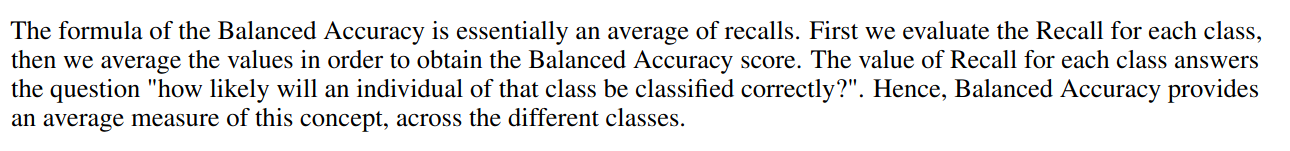

## Funciones auxiliares

### Imports

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import log_loss


### Configuración de almacenamiento de resultados

In [2]:
model_name = "RF (Dataset Final)" # <---------- MODIFICAR PARA QUE SE CORRESPONDA COM MODELO QUE SE ESTÁ EVALUANDO!
results_dir = "plots/evaluation/"

### Matriz de Confusión

In [3]:
def generate_confusion_matrix(y_true, y_pred, classes: list[str], plot_title: str, store_path: str):
  """
  Calcula matriz de confusión para y_true e y_pred, la grafica usando como labels las clases de "classses" y como título a "plot_title".
  El gráfico se almacena en results_dir (variable global).
  """
  
  n_classes = len(classes)
  labels = np.arange(n_classes)
  
  cm = confusion_matrix(y_true, y_pred, labels=labels)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

  fig, ax = plt.subplots()
  cm_display.plot(cmap="Reds", values_format="d", ax=ax)

  plt.title(plot_title)
  plt.savefig(store_path)
  plt.show()

  return cm


### Métricas - Decisiones

In [4]:
def generate_decision_metrics(confusion_matrix, classes: list[str], store_path: str):
  """
  Dada una matriz de confusión, calcula métricas de decisión y las almacena en un txt. 
  Imprime en pantalla lo almacenado.
  """
  n_predictions = np.sum(confusion_matrix)
  n_classes = len(classes)

  # Métricas x clase a calcular
  recall = np.zeros(n_classes)
  precision = np.zeros(n_classes)
  fpr = np.zeros(n_classes)
  F1 = np.zeros(n_classes)
  TP_total = 0

  for i in range(n_classes): 
    # Extrayendo TP, FN, FP y TN de la clase
    TP = confusion_matrix[i, i]
    FN = sum(confusion_matrix[i, :]) - TP
    FP = sum(confusion_matrix[:, i]) - TP
    TN = n_predictions - (TP + FN + FP)

    # Calcular métricas de la clase
    recall[i] = TP / (TP + FP)
    precision[i] = TP / (TP + FN)
    fpr[i] = FP / (FP + TN)
    F1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
    TP_total += TP

  # F1 macro - promedio de los F1 x clase
  F1_macro = F1.mean()

  # Accuracy global
  accuracy = TP_total / n_predictions

  # Balanced accuracy
  balanced_accuracy = recall.mean()

  # Store metrics
  with open(store_path, "w") as file:
    for i, class_name in enumerate(classes):  file.write(f"Recall {class_name}: {recall[i]}\n")
    file.write("\n")
    for i, class_name in enumerate(classes): file.write(f"Precision {class_name}: {precision[i]}\n")
    file.write("\n")
    for i, class_name in enumerate(classes): file.write(f"FPR {class_name}: {fpr[i]}\n")
    file.write("\n")
    for i, class_name in enumerate(classes): file.write(f"F1 {class_name}: {F1[i]}\n")
    file.write("\n")
    file.write(f"F1 Macro: {F1_macro}\n")
    file.write(f"Accuracy: {accuracy}\n")
    file.write(f"Balanced Accuracy: {balanced_accuracy}\n")

  # Print metrics
  with open(store_path, "r") as file:
    print(file.read())

### Métricas - Scores

In [5]:
def generate_scores_metrics(y_true, y_proba, classes: list[str], store_path: str):
  """
  Calcula métricas de score para y_true e y_proba, independientemente de la cantidad de clases. 
  Almacena los resultados en un txt y los imprime en pantalla.
  """

  n_classes = len(classes)

  # Métricas por clase a calcular
  auc_roc_score_ovr = np.zeros(n_classes)
  average_precision_score_ovr = np.zeros(n_classes)
  for i in range(n_classes): 
    # Métricas One-vs-Rest. Se toma una clase como positiva y al resto como negativas.
    y_true_ovr = y_true == i
    y_proba_ovr = y_proba[f"y_proba_{i}"]

    auc_roc_score_ovr[i] = roc_auc_score(y_true_ovr, y_proba_ovr)
    average_precision_score_ovr[i] = average_precision_score(y_true_ovr, y_proba_ovr)

  # Métricas OvR macro, revisar si esto sirve
  auc_roc_score_ovr_macro = auc_roc_score_ovr.mean()
  average_precision_score_ovr_macro = average_precision_score_ovr.mean()

  # Cross Entropy/Log Loss
  cross_entropy = log_loss(y_true, y_proba)

  # Store metrics
  with open(store_path, "w") as file:
    for i, class_name in enumerate(classes):  file.write(f"AUC ROC OvR {class_name}: {auc_roc_score_ovr[i]}\n")
    file.write("\n")
    for i, class_name in enumerate(classes): file.write(f"Average Precision OvR {class_name}: {average_precision_score_ovr[i]}\n")
    file.write("\n")
    file.write(f"Cross Entropy: {cross_entropy}\n")
    file.write(f"AUC ROC OvR Macro: {auc_roc_score_ovr_macro}\n")
    file.write(f"Average Precision Macro: {average_precision_score_ovr_macro}\n")

  # Print metrics
  with open(store_path, "r") as file:
    print(file.read())

### Gráficos

In [27]:
def graficar_roc_curves(y_true, y_proba, classes, title='Curvas ROC OvR', save_path=None, threshold_mark=None, ax=None):
  # Gráfico base
  show=False
  if ax is None:
    show = True
    fig, ax = plt.subplots()
  ax.plot([0, 1], [0, 1], 'k--', label='Random')
  ax.set_xlabel('FPR')
  ax.set_ylabel('TPR')
  ax.set_title(title)
  
  # Curva y label por clase
  for i, classname in enumerate(classes): 
    # Métricas One-vs-Rest. Se toma una clase como positiva y al resto como negativas.
    y_true_ovr = y_true == i
    y_proba_ovr = y_proba[f"y_proba_{i}"]

    score = roc_auc_score(y_true_ovr, y_proba_ovr)
    fpr, tpr, thresholds = roc_curve(y_true_ovr, y_proba_ovr)

    ax.plot(fpr, tpr, label=f'{classname} (AUC = {score:.2f})')

    if threshold_mark is not None:
        idx = (np.abs(thresholds - threshold_mark)).argmin()
        ax.scatter(fpr[idx], tpr[idx], color="red", s=80, label=f'Threshold={threshold_mark:.2f}')

    
  ax.legend()

  if save_path:
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
  if show:
    plt.show()




def graficar_precision_recall_curve(y_true, y_proba, classes, title='Precision-Recall Curve', save_path=None, ax=None):
  # Gráfico base
  show=False
  if ax is None:
    show = True
    fig, ax = plt.subplots()
  ax.set_xlabel('Recall')
  ax.set_ylabel('Precision')
  ax.set_title(title)

  # Curva y label por clase
  for i, classname in enumerate(classes): 
    # Métricas One-vs-Rest. Se toma una clase como positiva y al resto como negativas.
    y_true_ovr = y_true == i
    y_proba_ovr = y_proba[f"y_proba_{i}"]
    
    score = average_precision_score(y_true_ovr, y_proba_ovr)
    precision, recall, thresholds = precision_recall_curve(y_true_ovr, y_proba_ovr)
    ax.plot(recall, precision, label=f'{classname} (AUC = {score:.2f})')

  ax.legend()
  if save_path:
    plt.savefig(save_path)
  if show:
    plt.show()




## Capitalización 

### Input

In [7]:
df_test_cap = pd.read_csv('../data/processed/test_cap_rf.csv')

y_test_true_cap = df_test_cap["y_cap"]
y_test_pred_cap = df_test_cap["y_pred"]
y_test_proba_cap = df_test_cap[["y_proba_0", "y_proba_1", "y_proba_2", "y_proba_3"]] 

classes_cap = ['0 hola', '1 Hola', '2 iPhone', '3 UBA']
df_test_cap

,position,token_len,emb_norm,dist_prev,dist_next,is_subword,token_first_char,y_cap,y_pred,y_proba_0,y_proba_1,y_proba_2,y_proba_3
0,21,6,1.327367,1.726774,1.702730,0,116,0,0,1.00,0.00,0.00,0.00
1,58,3,1.016856,1.286378,1.246688,0,99,0,0,0.62,0.38,0.00,0.00
2,23,3,1.097381,1.331767,1.402987,0,109,0,0,1.00,0.00,0.00,0.00
3,134,3,1.159428,1.829334,1.931168,0,102,0,0,0.78,0.16,0.05,0.01
4,61,2,1.062491,1.417197,1.497784,0,101,0,0,0.75,0.25,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
889502,23,2,1.139708,1.252624,1.683042,0,110,0,0,0.97,0.03,0.00,0.00
889503,35,4,1.334938,1.648987,1.596047,0,115,0,0,0.98,0.01,0.01,0.00
889504,26,2,1.068887,1.150421,1.493373,0,115,0,0,1.00,0.00,0.00,0.00
889505,65,3,1.121860,1.388570,1.761441,0,116,0,0,0.80,0.14,0.00,0.06


### Matriz de confusión

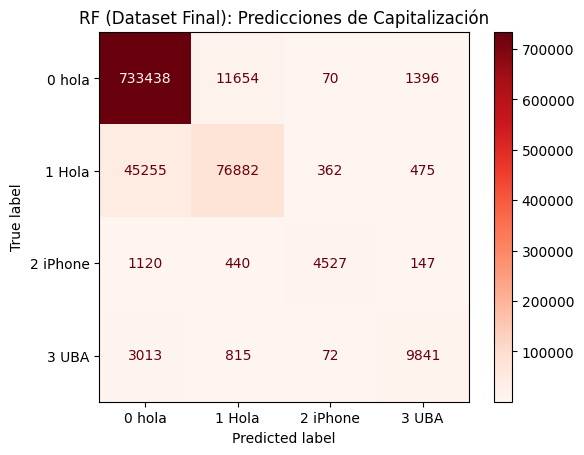

In [8]:
cm_cap = generate_confusion_matrix(
  y_test_true_cap, y_test_pred_cap, classes_cap, f"{model_name}: Predicciones de Capitalización",
  f"{results_dir}{model_name}_cap_confusion_matrix.png"  
)

### Métricas - Decisiones

In [9]:
generate_decision_metrics(cm_cap, classes_cap, f"{results_dir}{model_name}_cap_decision_metrics.txt")

Recall 0 hola: 0.9369106289264791
Recall 1 Hola: 0.8562328072969452
Recall 2 iPhone: 0.8998211091234347
Recall 3 UBA: 0.8298338814402564

Precision 0 hola: 0.982426013785935
Precision 1 Hola: 0.6251890643550669
Precision 2 iPhone: 0.7261790182868142
Precision 3 UBA: 0.7161778618732261

FPR 0 hola: 0.34549384745608575
FPR 1 Hola: 0.01684076223724223
FPR 2 iPhone: 0.0005706050111347228
FPR 3 UBA: 0.0023042684918117397

F1 0 hola: 0.959128642643051
F1 1 Hola: 0.7226940521232346
F1 2 iPhone: 0.8037283621837549
F1 3 UBA: 0.768828125

F1 Macro: 0.81359479548751
Accuracy: 0.9271292974647755
Balanced Accuracy: 0.8806996066967789



### Métricas - Scores

In [10]:
generate_scores_metrics(y_test_true_cap, y_test_proba_cap, classes_cap, f"{results_dir}{model_name}_cap_scores_metrics.txt")

AUC ROC OvR 0 hola: 0.9459923643799337
AUC ROC OvR 1 Hola: 0.9415005103273386
AUC ROC OvR 2 iPhone: 0.9552446979543658
AUC ROC OvR 3 UBA: 0.9656000712027155

Average Precision OvR 0 hola: 0.9858109929324764
Average Precision OvR 1 Hola: 0.819427943420574
Average Precision OvR 2 iPhone: 0.8003925041311245
Average Precision OvR 3 UBA: 0.8086120656187784

Cross Entropy: 0.29804375385719173
AUC ROC OvR Macro: 0.9520844109660884
Average Precision Macro: 0.8535608765257383



## Puntuación inicial 

### Input

In [11]:
df_test_ini = pd.read_csv('../data/processed/test_ini_rf.csv')

y_test_true_ini = df_test_ini["y_punt_ini"]
y_test_pred_ini = df_test_ini["y_pred"]
y_test_proba_ini = df_test_ini[["y_proba_0", "y_proba_1"]]

classes_ini = ['Sin puntuación', '¿']

### Matriz de confusión

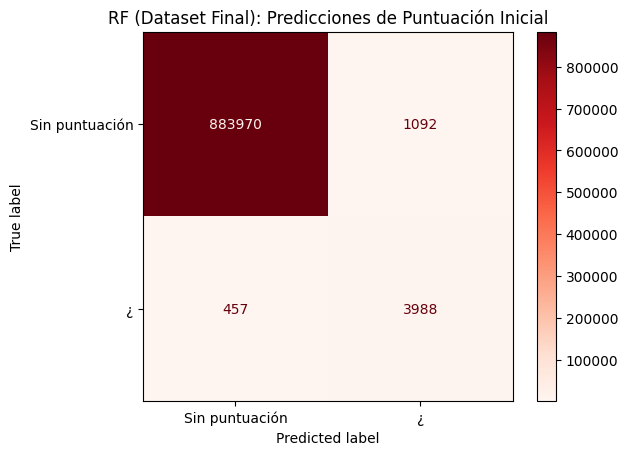

In [12]:
cm_ini = generate_confusion_matrix(
  y_test_true_ini, y_test_pred_ini, classes_ini, f"{model_name}: Predicciones de Puntuación Inicial", 
  f"{results_dir}{model_name}_ini_confusion_matrix.png"
)

### Métricas - Decisiones

In [13]:
generate_decision_metrics(cm_ini, classes_ini, f"{results_dir}{model_name}_ini_decision_metrics.txt")

Recall Sin puntuación: 0.9994832812657235
Recall ¿: 0.7850393700787401

Precision Sin puntuación: 0.9987661881314529
Precision ¿: 0.8971878515185602

FPR Sin puntuación: 0.10281214848143982
FPR ¿: 0.0012338118685470622

F1 Sin puntuación: 0.9991246060303285
F1 ¿: 0.8373753280839895

F1 Macro: 0.918249967057159
Accuracy: 0.9982585859358049
Balanced Accuracy: 0.8922613256722318



### Métricas - Scores

In [14]:
generate_scores_metrics(y_test_true_ini, y_test_proba_ini, classes_ini, f"{results_dir}{model_name}_ini_scores_metrics.txt")

AUC ROC OvR Sin puntuación: 0.9780679589842414
AUC ROC OvR ¿: 0.9780679591113353

Average Precision OvR Sin puntuación: 0.9997807486669376
Average Precision OvR ¿: 0.9230663538701663

Cross Entropy: 0.01172788005131489
AUC ROC OvR Macro: 0.9780679590477883
Average Precision Macro: 0.961423551268552



## Puntuación final

### Input

In [15]:
df_test_fin = pd.read_csv('../data/processed/test_fin_rf.csv')

y_test_true_fin = df_test_fin["y_punt_fin"]
y_test_pred_fin = df_test_fin["y_pred"]
y_test_proba_fin = df_test_fin[["y_proba_0", "y_proba_1", "y_proba_2", "y_proba_3"]]

classes_fin = ["Sin puntuación", ',', '.', '?']

### Matriz de confusión

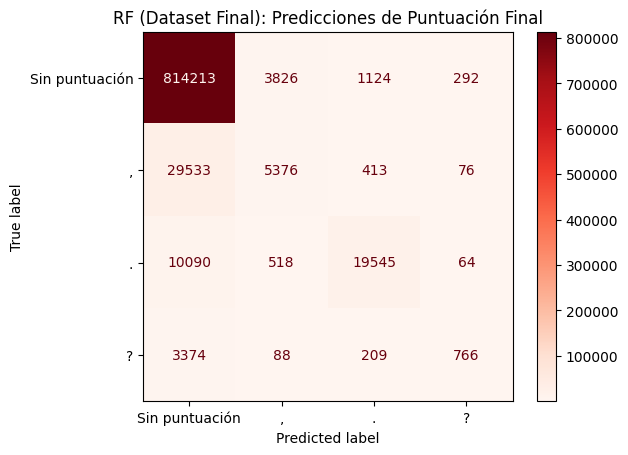

In [16]:
cm_fin = generate_confusion_matrix(
  y_test_true_fin, y_test_pred_fin, classes_fin, f"{model_name}: Predicciones de Puntuación Final", 
  f"{results_dir}{model_name}_fin_confusion_matrix.png"
)

### Métricas - Decisiones

In [17]:
generate_decision_metrics(cm_fin, classes_fin, f"{results_dir}{model_name}_fin_decision_metrics.txt")

Recall Sin puntuación: 0.9498407624736063
Recall ,: 0.5481239804241436
Recall .: 0.9179935183880513
Recall ?: 0.6393989983305509

Precision Sin puntuación: 0.9936030654520382
Precision ,: 0.15187298717441663
Precision .: 0.6468213257437866
Precision ?: 0.17263917061077305

FPR Sin puntuación: 0.6137869011591389
FPR ,: 0.005189033249854527
FPR .: 0.0020319100652864573
FPR ?: 0.0004880969866790197

F1 Sin puntuación: 0.9712291960528788
F1 ,: 0.23784453391142768
F1 .: 0.7589112370893841
F1 ?: 0.27187222715173026

F1 Macro: 0.5599642985513552
Accuracy: 0.9442309054341338
Balanced Accuracy: 0.7638393149040881



### Métricas - Scores

In [18]:
generate_scores_metrics(y_test_true_fin, y_test_proba_fin, classes_fin, f"{results_dir}{model_name}_fin_scores_metrics.txt")

AUC ROC OvR Sin puntuación: 0.9157512713881968
AUC ROC OvR ,: 0.8712634942465737
AUC ROC OvR .: 0.9517766004509411
AUC ROC OvR ?: 0.9063317307153271

Average Precision OvR Sin puntuación: 0.9908390045368619
Average Precision OvR ,: 0.29207145376145516
Average Precision OvR .: 0.7649875660728298
Average Precision OvR ?: 0.27599829310439955

Cross Entropy: 0.28768317090364337
AUC ROC OvR Macro: 0.9112807742002597
Average Precision Macro: 0.5809740793688866



## Gráficos

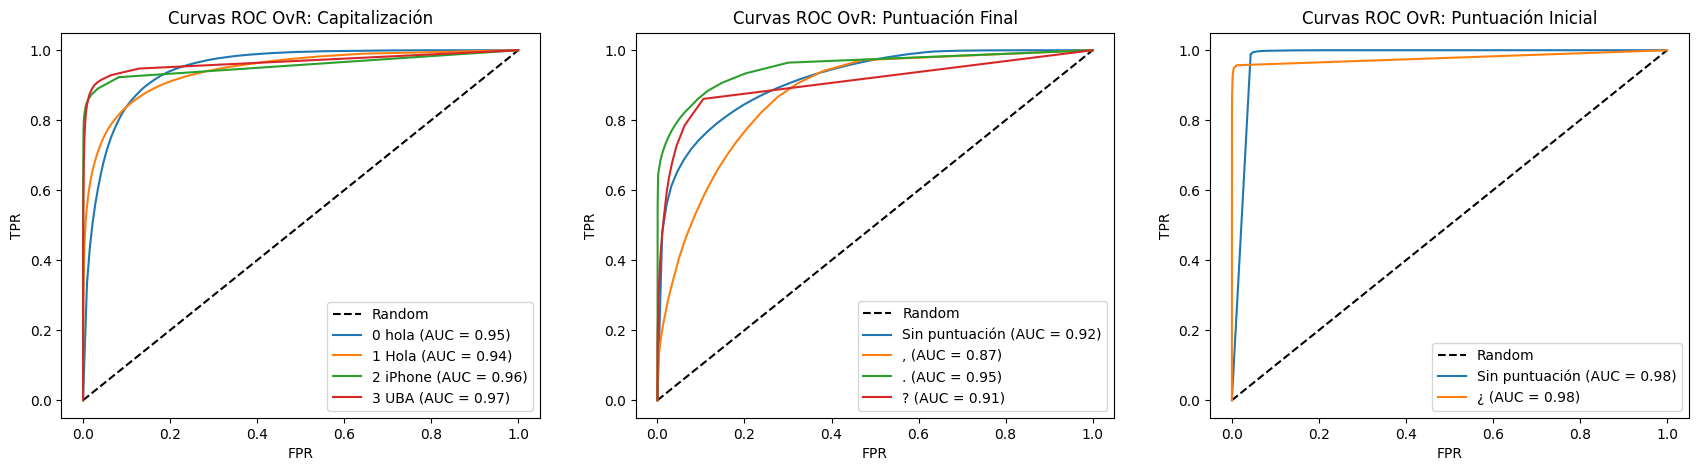

In [19]:
fig, ax = plt.subplots(1, 3, figsize=[21, 5])
sns.set_palette('viridis')
graficar_roc_curves(y_test_true_cap,  y_test_proba_cap, classes_cap, "Curvas ROC OvR: Capitalización", f"{results_dir}{model_name}_cap_auc_roc.png", ax=ax[0])
graficar_roc_curves(y_test_true_fin,  y_test_proba_fin, classes_fin, "Curvas ROC OvR: Puntuación Final", f"{results_dir}{model_name}_fin_auc_roc.png", ax=ax[1])
graficar_roc_curves(y_test_true_ini,  y_test_proba_ini, classes_ini, "Curvas ROC OvR: Puntuación Inicial", f"{results_dir}{model_name}_ini_auc_roc.png", ax=ax[2])

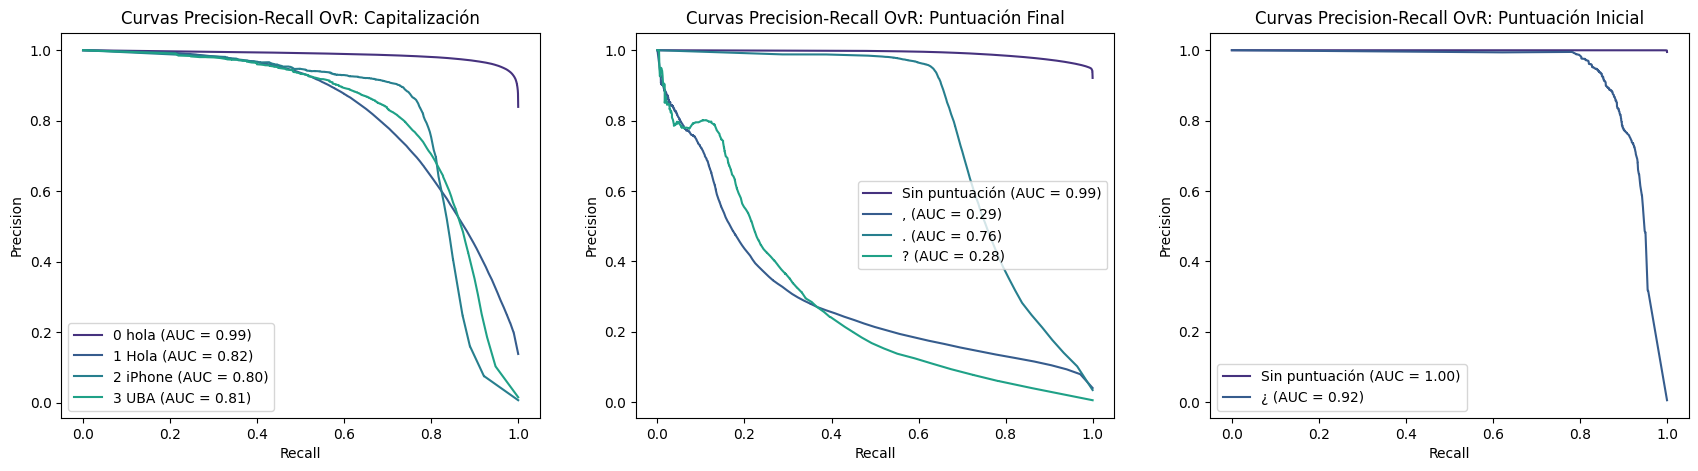

In [28]:
fig, ax = plt.subplots(1, 3, figsize=[21, 5])

graficar_precision_recall_curve(y_test_true_cap, y_test_proba_cap, classes_cap, "Curvas Precision-Recall OvR: Capitalización", f"{results_dir}{model_name}_cap_auc_pr.png", ax=ax[0])
graficar_precision_recall_curve(y_test_true_fin, y_test_proba_fin, classes_fin, "Curvas Precision-Recall OvR: Puntuación Final", f"{results_dir}{model_name}_fin_auc_pr.png", ax=ax[1])
graficar_precision_recall_curve(y_test_true_ini, y_test_proba_ini, classes_ini, "Curvas Precision-Recall OvR: Puntuación Inicial", f"{results_dir}{model_name}_ini_auc_pr.png", ax=ax[2])